In [31]:
import numpy as np
import os, sys
from skimage import io
import tifffile
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import neuroglancer
from PIL import Image
from scipy.ndimage import zoom

In [52]:
input = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/MD657/preps/tif'
infile = '001.tif'
filepath = os.path.join(input, infile)
arr = tifffile.imread(filepath)
print(arr.shape, arr.dtype, arr.ndim)

(832, 847, 3) uint16 3


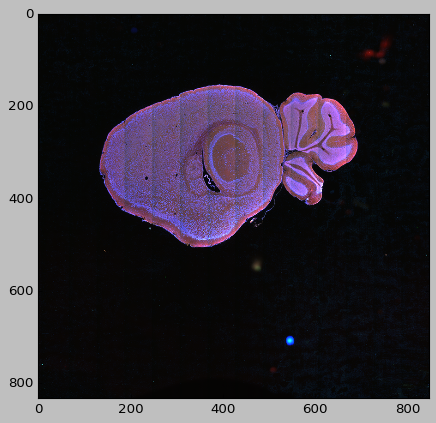

In [53]:
plt.style.use('classic')
plt.imshow(arr, cmap="gray")
plt.show()

In [56]:
# Rescale 16-bit to 8-bit
img_rescaled = 255 * (arr - arr.min()) / (arr.max() - arr.min())
# Colourising image and saving it with opencv
img = cv2.applyColorMap(img_rescaled.astype(np.uint8), cv2.COLORMAP_INFERNO)
print(img.shape, img.dtype, img.ndim)
cv2outpath = os.path.join(input, 'arr001.tif')
tifffile.imwrite(cv2outpath, img, compression='LZW', bigtiff=True)


(832, 847, 3) uint8 3


In [62]:
img = cv2.imread(filepath, 1)
scale = 250
dtype = img.dtype
epsilon = 0.99    
_max = np.quantile(img[img>0], epsilon)
scaled = (img * (scale / _max)).astype(dtype) # scale the image from original values to a broader range of values

print(scaled.shape, scaled.dtype, scaled.ndim)
#cv2outpath = os.path.join(input, 'arr001.tif')
#tifffile.imwrite(cv2outpath, img, compression='LZW', bigtiff=True)

(832, 847, 3) uint8 3


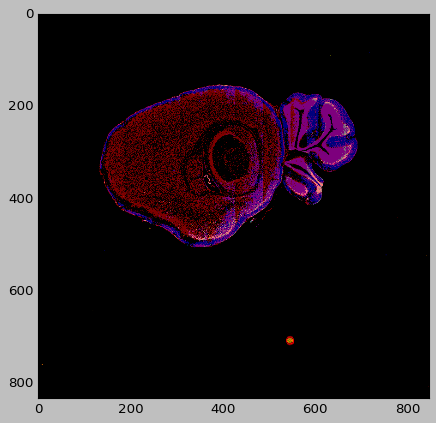

In [63]:
plt.imshow(scaled, cmap="seismic")
plt.show()

In [ ]:
animal = 'DK55'
ROOT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data'

boundary_tiff_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'boundaries.tiff')
boundary_np_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'zoomed_sagittal_boundary.npy')
#volume = io.imread(boundary_tiff_path)
volume = np.load(boundary_np_path)
#downsampled_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'downsampled.tiff')
#downsampled_stack = io.imread(downsampled_path)

#atlas_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'registered_atlas_original_orientation.tiff')
#atlas_stack = io.imread(atlas_path)
print(volume.shape, volume.dtype)

In [ ]:
fpath = os.path.join(ROOT, animal,  'preps/CH1/thumbnail_aligned')
files = os.listdir(fpath)
z = len(files)
midfile = str(z // 2).zfill(3) + ".tif"
midfilepath = os.path.join(ROOT, animal,  f'preps/CH1/thumbnail_aligned/{midfile}')
mid_arr = io.imread(midfilepath)
print(midfile,mid_arr.shape, z) 

In [ ]:
print(volume.shape, volume.dtype, np.amin(volume), np.amax(volume), np.mean(volume))

In [ ]:
#arr = np.rot90(arr, 3)
midsection = volume.shape[2] // 2 
n = 4
start = midsection - n
end = midsection + n
plt.style.use('classic')
for i in range(start, end,1):
    img = volume[:,:,i]
    img[img > 0] = 255
    print(img.dtype, img.shape)
    #img = np.rot90(img, 3)
    #img = np.flip(img, axis=1)
    plt.title('Z {}'.format(i))
    plt.imshow(img, cmap="gray")
    plt.show()

In [ ]:
boundary_outpath = os.path.join(ROOT, animal, 'preps/CH1/boundary')
os.makedirs(boundary_outpath, exist_ok=True)
arr = volume.copy()
endsection = arr.shape[2]   
for i in tqdm(range(0, endsection, 1)):
    img = arr[:,:,i]
    img[img > 0] = 255
    f = str(i).zfill(3) + '.tif'
    outpath = os.path.join(boundary_outpath, f)
    cv2.imwrite(outpath, img)
    


In [ ]:
sagittal_arr = sagittal_arr.astype(np.uint8)
print(sagittal_arr.shape, sagittal_arr.dtype)
midsection = sagittal_arr.shape[2] // 2 
n = 2
start = midsection - n
end = midsection + n
plt.style.use('classic')
for i in range(start, end,1):
    img = sagittal_arr[:,:,i]
    plt.title('Z {}'.format(i))
    plt.imshow(img, cmap="gray")
    plt.show()

In [ ]:
sagittal_np_path = os.path.join(ROOT, animal, 'preps/CH1/brainreg_allen', 'sagittal_boundary')
np.save(sagittal_np_path, sagittal_arr)

In [ ]:
change_y = mid_arr.shape[0] / sagittal_arr.shape[0]
change_x = mid_arr.shape[1] / sagittal_arr.shape[1]
change_z = z / sagittal_arr.shape[2]
print(change_y, change_x, change_z)

In [ ]:
zatlas = zoom(sagittal_arr, (change_y, change_x, change_z))
print('zatlas',zatlas.shape)
print('volume', mid_arr.shape, z)

In [ ]:
dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[10.4, 10.4, 20])

viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layers['Altas'] = neuroglancer.ImageLayer(
        source=neuroglancer.LocalVolume(
            data=volume,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ),
        shader="""
#uicontrol invlerp normalized

void main() {
    float pix =  normalized();
  	  emitGrayscale(pix) ;
}
""")
print(viewer)

In [ ]:
OUTPATH = os.path.join(HOME, 'work','tifs')
arr = volume.copy()
arr = np.rot90(arr, 3)
start = 0
end = arr.shape[2]
for i in range(start, end,1):
    outfile = str(i).zfill(3) + '.tif'
    outpath = os.path.join(OUTPATH, outfile)
    cv2.imwrite(outpath, arr[:,:,i])